# CNN Model Development

### Import Libraries and Set Seed

In [1]:
# Import necessary libraries
import os
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
# Set random seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

### Load and Preprocess Data

In [3]:
# Path to dataset
DATA_FOLDER_BASELINE = "images"  # Directory containing images for baseline model
CSV_FILE_BASELINE = "styles.csv"  # CSV file with filenames and labels for baseline model

In [ ]:
from google.colab import drive
import zipfile
import os

# Mount Google Drive
drive.mount('/content/drive')

# Path to the zip file in your Drive
zip_file_path = '/content/drive/MyDrive/fashion_data.zip'  # Replace with your actual path

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')  # Extract to a folder named 'dataset'

# Update data paths
DATA_FOLDER_BASELINE = '/content/dataset/fashion_data/images'  # Assuming 'images' is inside the extracted folder
CSV_FILE_BASELINE = '/content/dataset/fashion_data/styles.csv'  # Assuming 'styles.csv' is inside the extracted folder

In [4]:
df_baseline = pd.read_csv(CSV_FILE_BASELINE, on_bad_lines='skip')
print(f"Baseline CSV loaded successfully with {len(df_baseline)} rows.")

Baseline CSV loaded successfully with 44424 rows.


In [5]:
# Filter the necessary columns and classes for baseline
valid_classes = ["Casual", "Formal", "Smart Casual"]
df_baseline = df_baseline[["id", "usage"]]
df_baseline = df_baseline[df_baseline["usage"].isin(valid_classes)].reset_index(drop=True)

In [6]:
# Map classes to indices
df_baseline["label_index"] = df_baseline["usage"].map({cls: idx for idx, cls in enumerate(valid_classes)})

In [7]:
# Split data into training, validation, and testing sets for baseline
train_df_baseline, test_df_baseline = train_test_split(df_baseline, test_size=0.2, random_state=SEED, stratify=df_baseline["label_index"])
train_df_baseline, val_df_baseline = train_test_split(train_df_baseline, test_size=0.25, random_state=SEED, stratify=train_df_baseline["label_index"])

In [8]:
# Verify splits
print(f"Baseline - Training samples: {len(train_df_baseline)}, Validation samples: {len(val_df_baseline)}, Testing samples: {len(test_df_baseline)}")

Baseline - Training samples: 22090, Validation samples: 7364, Testing samples: 7364


In [9]:
# Convert 'id' column to string for compatibility
train_df_baseline["id"] = train_df_baseline["id"].astype(str)
val_df_baseline["id"] = val_df_baseline["id"].astype(str)
test_df_baseline["id"] = test_df_baseline["id"].astype(str)

# Convert 'label_index' to strings
train_df_baseline["label_index"] = train_df_baseline["label_index"].astype(str)
val_df_baseline["label_index"] = val_df_baseline["label_index"].astype(str)
test_df_baseline["label_index"] = test_df_baseline["label_index"].astype(str)

# Verify the conversion
print(train_df_baseline.head())

          id   usage label_index
6970   12419  Casual           0
27504   9579  Casual           0
31525   6787  Casual           0
5578    9581  Casual           0
12234  51503  Casual           0


In [10]:
train_df_baseline.head()

,id,usage,label_index
6970,12419,Casual,0
27504,9579,Casual,0
31525,6787,Casual,0
5578,9581,Casual,0
12234,51503,Casual,0


In [11]:
# Check the first few paths
print(train_df_baseline["id"].iloc[0])  # Should match an actual filename in the 'images' folder
print(os.path.join(DATA_FOLDER_BASELINE, train_df_baseline["id"].iloc[0]))  # Full path to the first image


12419
images\12419


In [12]:
# Add extensions to filenames if needed
train_df_baseline["id"] += ".jpg"
val_df_baseline["id"] += ".jpg"
test_df_baseline["id"] += ".jpg"

In [13]:
print("Is DATA_FOLDER valid?", os.path.exists(DATA_FOLDER_BASELINE))
print("Example files in DATA_FOLDER:", os.listdir(DATA_FOLDER_BASELINE)[:5])


Is DATA_FOLDER valid? True
Example files in DATA_FOLDER: ['10000.jpg', '10001.jpg', '10002.jpg', '10003.jpg', '10004.jpg']


In [14]:
# Check if the first image exists
example_path = os.path.join(DATA_FOLDER_BASELINE, train_df_baseline["id"].iloc[0])
print("Does the first image exist?", os.path.exists(example_path))


Does the first image exist? True


### Data Generators for Baseline Model

In [15]:
# Only rescale for baseline model (no augmentation)
baseline_train_datagen = ImageDataGenerator(rescale=1.0 / 255)
baseline_val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

In [16]:
# Create data generators
baseline_train_generator = baseline_train_datagen.flow_from_dataframe(
    train_df_baseline,
    directory=DATA_FOLDER_BASELINE,
    x_col="id",
    y_col="label_index",
    target_size=(128, 128),
    batch_size=32,
    class_mode="sparse"
)

baseline_val_generator = baseline_val_test_datagen.flow_from_dataframe(
    val_df_baseline,
    directory=DATA_FOLDER_BASELINE,
    x_col="id",
    y_col="label_index",
    target_size=(128, 128),
    batch_size=32,
    class_mode="sparse"
)

baseline_test_generator = baseline_val_test_datagen.flow_from_dataframe(
    test_df_baseline,
    directory=DATA_FOLDER_BASELINE,
    x_col="id",
    y_col="label_index",
    target_size=(128, 128),
    batch_size=32,
    class_mode="sparse",
    shuffle=False
)

Found 22087 validated image filenames belonging to 3 classes.


D:\BUB\L6\Deep Learning\deepLearning\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 3 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  warnings.warn(


Found 7362 validated image filenames belonging to 3 classes.


D:\BUB\L6\Deep Learning\deepLearning\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 2 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  warnings.warn(


Found 7364 validated image filenames belonging to 3 classes.


### Baseline CNN Model


In [17]:
# Define a simple CNN model
baseline_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(valid_classes), activation='softmax')
])

baseline_model.compile(optimizer=Adam(learning_rate=0.0001),
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])


D:\BUB\L6\Deep Learning\deepLearning\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
# Train the baseline model
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

baseline_history = baseline_model.fit(
    baseline_train_generator,
    validation_data=baseline_val_generator,
    epochs=15,
    callbacks=[early_stopping]
)

Epoch 1/15


D:\BUB\L6\Deep Learning\deepLearning\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


691/691 ━━━━━━━━━━━━━━━━━━━━ 752s 1s/step - accuracy: 0.9319 - loss: 0.2320 - val_accuracy: 0.9583 - val_loss: 0.1464
Epoch 2/15
691/691 ━━━━━━━━━━━━━━━━━━━━ 72s 104ms/step - accuracy: 0.9585 - loss: 0.1313 - val_accuracy: 0.9662 - val_loss: 0.1094
Epoch 3/15
691/691 ━━━━━━━━━━━━━━━━━━━━ 72s 104ms/step - accuracy: 0.9649 - loss: 0.1148 - val_accuracy: 0.9648 - val_loss: 0.1135
Epoch 4/15
691/691 ━━━━━━━━━━━━━━━━━━━━ 72s 104ms/step - accuracy: 0.9660 - loss: 0.1048 - val_accuracy: 0.9693 - val_loss: 0.1013
Epoch 5/15
691/691 ━━━━━━━━━━━━━━━━━━━━ 72s 104ms/step - accuracy: 0.9688 - loss: 0.0947 - val_accuracy: 0.9700 - val_loss: 0.0941
Epoch 6/15
691/691 ━━━━━━━━━━━━━━━━━━━━ 72s 104ms/step - accuracy: 0.9706 - loss: 0.0873 - val_accuracy: 0.9704 - val_loss: 0.1013
Epoch 7/15
691/691 ━━━━━━━━━━━━━━━━━━━━ 72s 104ms/step - accuracy: 0.9731 - loss: 0.0773 - val_accuracy: 0.9708 - val_loss: 0.0867
Epoch 8/15
691/691 ━━━━━━━━━━━━━━━━━━━━ 72s 104ms/step - accuracy: 0.9757 - loss: 0.0698 - val_a

### Load and Preprocess Data for Enhanced Model

In [19]:
# Path to dataset
DATA_FOLDER_ENHANCED = "images"  # Directory containing images for enhanced model
CSV_FILE_ENHANCED = "styles.csv"  # CSV file with filenames and labels for enhanced model

# Load the CSV file for enhanced model
df_enhanced = pd.read_csv(CSV_FILE_ENHANCED, on_bad_lines='skip')
print(f"Enhanced CSV loaded successfully with {len(df_enhanced)} rows.")


Enhanced CSV loaded successfully with 44424 rows.


In [20]:
# Filter the necessary columns and classes for enhanced
valid_classes = ["Casual", "Formal", "Smart Casual"]
df_enhanced = df_enhanced[["id", "usage"]]
df_enhanced = df_enhanced[df_enhanced["usage"].isin(valid_classes)].reset_index(drop=True)

# Map classes to indices
df_enhanced["label_index"] = df_enhanced["usage"].map({cls: idx for idx, cls in enumerate(valid_classes)})


In [21]:
# Split data into training, validation, and testing sets for enhanced
train_df_enhanced, test_df_enhanced = train_test_split(df_enhanced, test_size=0.2, random_state=SEED, stratify=df_enhanced["label_index"])
train_df_enhanced, val_df_enhanced = train_test_split(train_df_enhanced, test_size=0.25, random_state=SEED, stratify=train_df_enhanced["label_index"])

# Verify splits
print(f"Enhanced - Training samples: {len(train_df_enhanced)}, Validation samples: {len(val_df_enhanced)}, Testing samples: {len(test_df_enhanced)}")


Enhanced - Training samples: 22090, Validation samples: 7364, Testing samples: 7364


In [22]:
# Convert 'id' column to string for compatibility
train_df_enhanced["id"] = train_df_enhanced["id"].astype(str)
val_df_enhanced["id"] = val_df_enhanced["id"].astype(str)
test_df_enhanced["id"] = test_df_enhanced["id"].astype(str)

# Convert 'label_index' to strings
train_df_enhanced["label_index"] = train_df_enhanced["label_index"].astype(str)
val_df_enhanced["label_index"] = val_df_enhanced["label_index"].astype(str)
test_df_enhanced["label_index"] = test_df_enhanced["label_index"].astype(str)

# Verify the conversion
print(train_df_enhanced.head())


          id   usage label_index
6970   12419  Casual           0
27504   9579  Casual           0
31525   6787  Casual           0
5578    9581  Casual           0
12234  51503  Casual           0


In [23]:
# Check the first few paths
print(train_df_enhanced["id"].iloc[0])  # Should match an actual filename in the 'images' folder
print(os.path.join(DATA_FOLDER_ENHANCED, train_df_enhanced["id"].iloc[0]))  # Full path to the first image


12419
images\12419


In [24]:
# Add extensions to filenames if needed
train_df_enhanced["id"] += ".jpg"
val_df_enhanced["id"] += ".jpg"
test_df_enhanced["id"] += ".jpg"

### Data Generators for Enhanced Model

In [25]:
# Enhanced data augmentation for the enhanced model
enhanced_train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,  # Increased rotation for more variation
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],  # Adjust brightness to handle varying lighting
    preprocessing_function=lambda x: x + tf.random.normal(tf.shape(x), mean=0.0, stddev=0.05)  # Add Gaussian noise
)

# Validation and testing generator without augmentation (only rescaling)
enhanced_val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Create data generators
enhanced_train_generator = enhanced_train_datagen.flow_from_dataframe(
    train_df_enhanced,
    directory=DATA_FOLDER_ENHANCED,
    x_col="id",
    y_col="label_index",
    target_size=(128, 128),
    batch_size=64,
    class_mode="sparse"
)

enhanced_val_generator = enhanced_val_test_datagen.flow_from_dataframe(
    val_df_enhanced,
    directory=DATA_FOLDER_ENHANCED,
    x_col="id",
    y_col="label_index",
    target_size=(128, 128),
    batch_size=64,
    class_mode="sparse"
)

enhanced_test_generator = enhanced_val_test_datagen.flow_from_dataframe(
    test_df_enhanced,
    directory=DATA_FOLDER_ENHANCED,
    x_col="id",
    y_col="label_index",
    target_size=(128, 128),
    batch_size=64,
    class_mode="sparse",
    shuffle=False
)


Found 22087 validated image filenames belonging to 3 classes.


D:\BUB\L6\Deep Learning\deepLearning\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 3 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  warnings.warn(
D:\BUB\L6\Deep Learning\deepLearning\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 2 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  warnings.warn(


Found 7362 validated image filenames belonging to 3 classes.
Found 7364 validated image filenames belonging to 3 classes.


### Enhanced CNN with Transfer Learning and Visualization

In [26]:
# Use a pretrained model (VGG16) as a base
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Enable fine-tuning for the last 2 convolutional blocks
for layer in base_model.layers[:-8]:  # Freeze all layers except the last 8
    layer.trainable = False

# Add custom layers on top
enhanced_model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),  # Increased neurons for richer feature extraction
    layers.BatchNormalization(),  # Added batch normalization to stabilize training
    layers.Dropout(0.5),  # Regularization
    layers.Dense(len(valid_classes), activation='softmax')  # Final classification layer
])

# Compile the model with a smaller learning rate for fine-tuning
enhanced_model.compile(optimizer=Adam(learning_rate=0.0005),  # Smaller learning rate for fine-tuning
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])


In [27]:
# Train the enhanced model
enhanced_history = enhanced_model.fit(
    enhanced_train_generator,
    validation_data=enhanced_val_generator,
    epochs=10
)

D:\BUB\L6\Deep Learning\deepLearning\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 657s 2s/step - accuracy: 0.6906 - loss: 0.8089 - val_accuracy: 0.9344 - val_loss: 0.2057
Epoch 2/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 657s 2s/step - accuracy: 0.9288 - loss: 0.2267 - val_accuracy: 0.9344 - val_loss: 0.4856
Epoch 3/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 660s 2s/step - accuracy: 0.9339 - loss: 0.1971 - val_accuracy: 0.9491 - val_loss: 0.1465
Epoch 4/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 744s 2s/step - accuracy: 0.9399 - loss: 0.1761 - val_accuracy: 0.9459 - val_loss: 0.1698
Epoch 5/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 745s 2s/step - accuracy: 0.9444 - loss: 0.1598 - val_accuracy: 0.3022 - val_loss: 1.3130
Epoch 6/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 950s 3s/step - accuracy: 0.9461 - loss: 0.1597 - val_accuracy: 0.9355 - val_loss: 0.2818
Epoch 7/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 1044s 3s/step - accuracy: 0.9529 - loss: 0.1380 - val_accuracy: 0.8625 - val_loss: 0.3384
Epoch 8/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 1178s 3s/step - accuracy: 0.9522 - loss: 0.1405 - val_ac

In [36]:
baseline_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,915,083 (37.82 MB)

 Trainable params: 3,305,027 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,610,056 (25.22 MB)

In [38]:
enhanced_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       4,194,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,266,251 (203.19 MB)

 Trainable params: 17,176,579 (65.52 MB)

 Non-trainable params: 1,736,512 (6.62 MB)

 Optimizer params: 34,353,160 (131.05 MB)

# Evaluate Models

In [28]:
# Evaluate baseline model
baseline_eval = baseline_model.evaluate(baseline_test_generator)
print(f"Baseline Model - Loss: {baseline_eval[0]}, Accuracy: {baseline_eval[1]}")

231/231 ━━━━━━━━━━━━━━━━━━━━ 339s 1s/step - accuracy: 0.9687 - loss: 0.0886
Baseline Model - Loss: 0.08982107043266296, Accuracy: 0.9716187119483948


In [29]:
# Evaluate enhanced model
enhanced_eval = enhanced_model.evaluate(enhanced_test_generator)
print(f"Enhanced Model - Loss: {enhanced_eval[0]}, Accuracy: {enhanced_eval[1]}")

116/116 ━━━━━━━━━━━━━━━━━━━━ 110s 943ms/step - accuracy: 0.8694 - loss: 0.3303
Enhanced Model - Loss: 0.3307873606681824, Accuracy: 0.8658337593078613


### Visualization of Model Accuracy


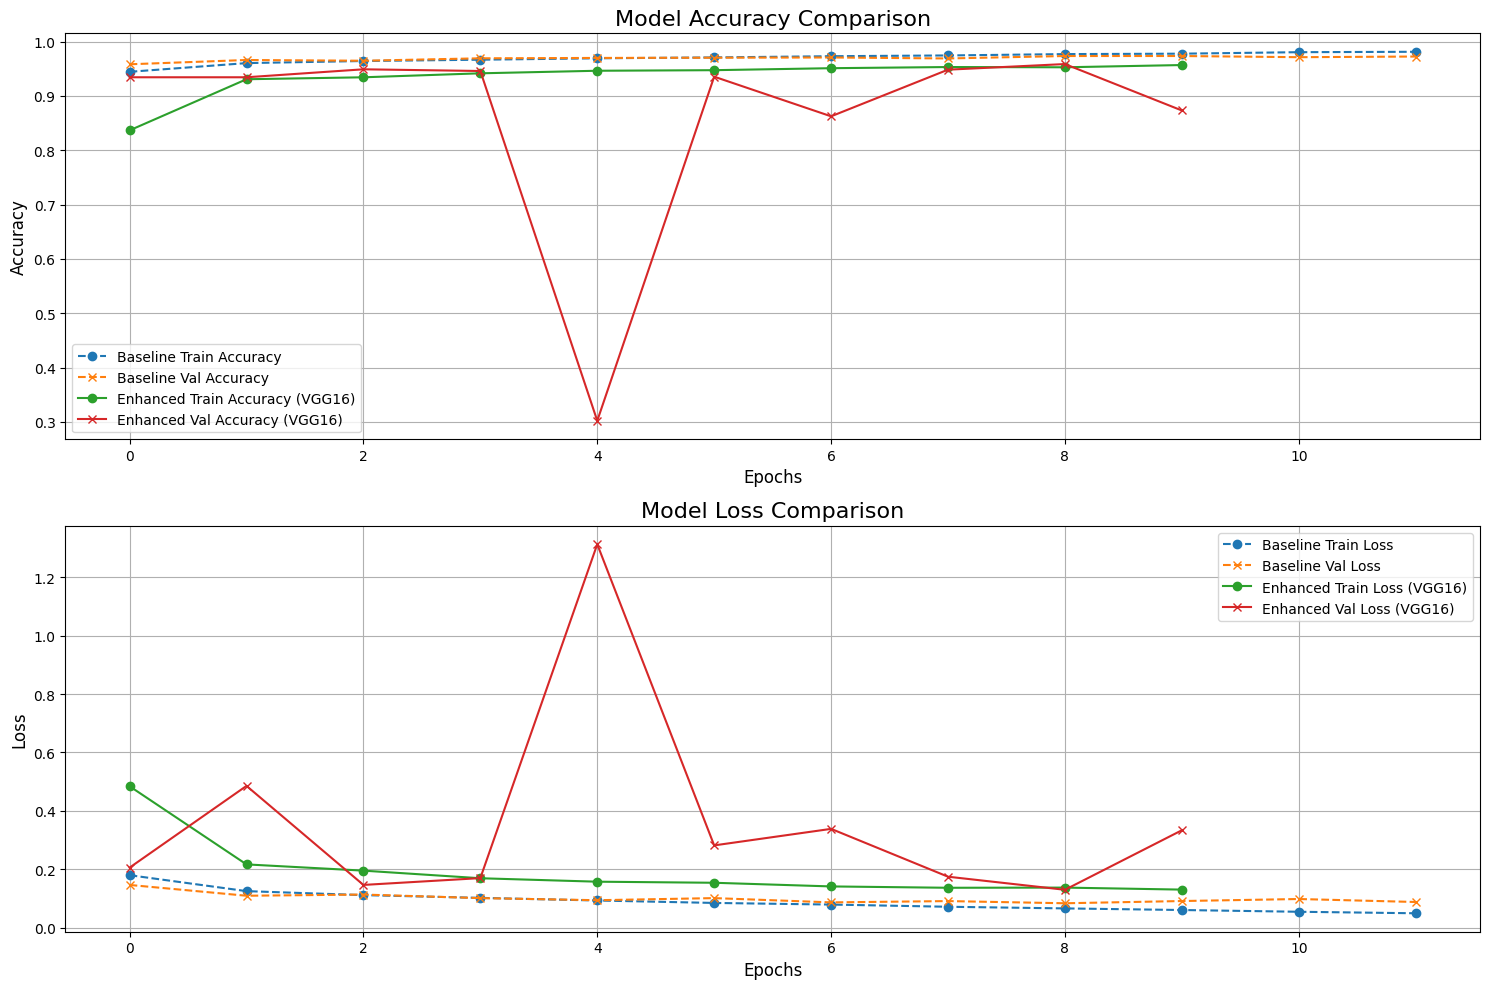

In [30]:
# Comprehensive plot for accuracy, loss, and comparison across epochs
plt.figure(figsize=(15, 10))

# Plot training and validation accuracy for all models
plt.subplot(2, 1, 1)
plt.plot(baseline_history.history['accuracy'], label='Baseline Train Accuracy', linestyle='--', marker='o')
plt.plot(baseline_history.history['val_accuracy'], label='Baseline Val Accuracy', linestyle='--', marker='x')
plt.plot(enhanced_history.history['accuracy'], label='Enhanced Train Accuracy (VGG16)', linestyle='-', marker='o')
plt.plot(enhanced_history.history['val_accuracy'], label='Enhanced Val Accuracy (VGG16)', linestyle='-', marker='x')
plt.title('Model Accuracy Comparison', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True)

# Plot training and validation loss for all models
plt.subplot(2, 1, 2)
plt.plot(baseline_history.history['loss'], label='Baseline Train Loss', linestyle='--', marker='o')
plt.plot(baseline_history.history['val_loss'], label='Baseline Val Loss', linestyle='--', marker='x')
plt.plot(enhanced_history.history['loss'], label='Enhanced Train Loss (VGG16)', linestyle='-', marker='o')
plt.plot(enhanced_history.history['val_loss'], label='Enhanced Val Loss (VGG16)', linestyle='-', marker='x')
plt.title('Model Loss Comparison', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True)

plt.tight_layout()
plt.show()


In [49]:
print("Model Names Length:", len(model_names))
print("Accuracy Scores Length:", len(accuracy_scores))
print("Loss Scores Length:", len(loss_scores))


Model Names Length: 2
Accuracy Scores Length: 3
Loss Scores Length: 3


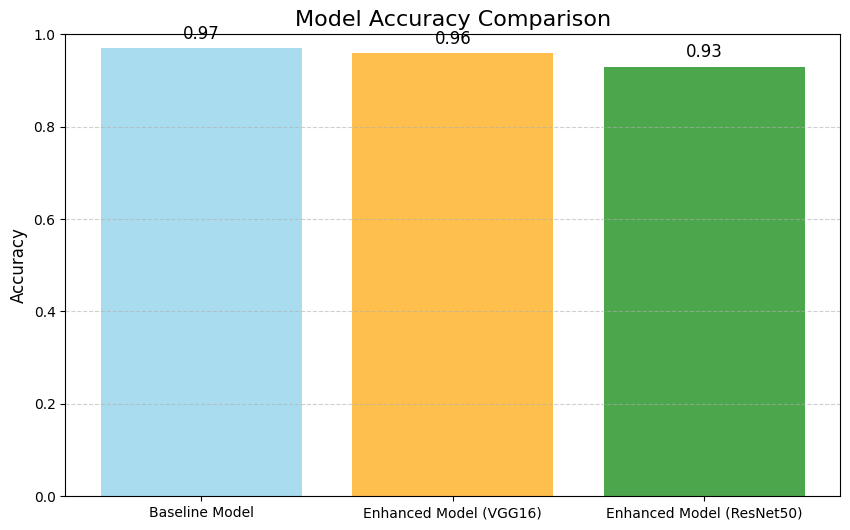

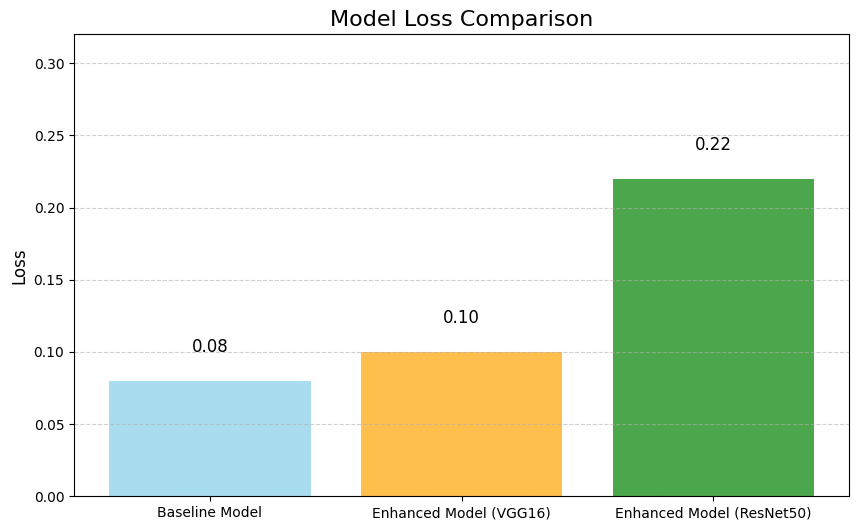

In [54]:
import matplotlib.pyplot as plt

# Aligned data
model_names = ['Baseline Model', 'Enhanced Model (VGG16)', 'Enhanced Model (ResNet50)']
accuracy_scores = [0.97, 0.96, 0.93]
loss_scores = [0.08, 0.10, 0.22]

# Plot and save accuracy comparison
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracy_scores, color=['skyblue', 'orange', 'green'], alpha=0.7)
plt.title('Model Accuracy Comparison', fontsize=16)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
for i, v in enumerate(accuracy_scores):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=12)

# Save the figure
plt.savefig("model_accuracy_comparison.png", dpi=300, bbox_inches='tight')  # Save as PNG
plt.show()

# Plot and save loss comparison
plt.figure(figsize=(10, 6))
plt.bar(model_names, loss_scores, color=['skyblue', 'orange', 'green'], alpha=0.7)
plt.title('Model Loss Comparison', fontsize=16)
plt.ylabel('Loss', fontsize=12)
plt.ylim(0, max(loss_scores) + 0.1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
for i, v in enumerate(loss_scores):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=12)

# Save the figure
plt.savefig("model_loss_comparison.png", dpi=300, bbox_inches='tight')  # Save as PNG
plt.show()
